In [ ]:
!pip install pandas

In [ ]:
import pandas as pd
import numpy as np
import re #função para limpeza nos textos

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer #converter os textos em uma matriz
from sklearn.feature_extraction.text import TfidfTransformer #frequencia que o termo aparece
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

#algoritmos
from sklearn.svm import LinearSVC, SVC # dados lineares / não lineares

#gráficos
import seaborn as sns

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving all-data.csv to all-data.csv


In [ ]:
df = pd.read_csv("/content/all-data.csv")

In [ ]:
df.head(5)

,sentiment,text
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [ ]:
df.shape

(4846, 2)

In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
neutral,2879
positive,1363
negative,604


<Axes: xlabel='sentiment', ylabel='count'>

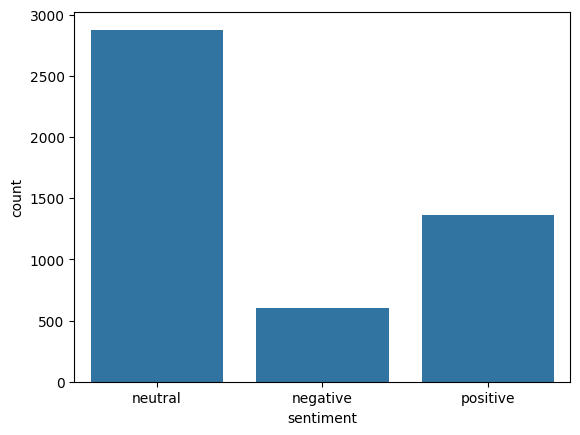

In [ ]:
sns.countplot(x="sentiment", data=df) # Quantidade de classes

**Pré-processamento**

In [ ]:
!pip install nltk

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

# Baixar pacotes necessários do NLTK
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('punkt_tab') # Download the 'punkt_tab' resource

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
def preprocess_text(text):
    # Converter para minúsculas
    text = text.lower()

    # Remover caracteres especiais e números
    text = re.sub(r"[^a-zA-Z\s]", "", text)

    # Tokenização (dividir em palavras)
    tokens = word_tokenize(text)

    # Remover stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [word for word in tokens if word not in stop_words]

    # Lematização (reduzir palavras à sua forma base)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Juntar as palavras processadas de volta em uma string
    return " ".join(tokens)

In [ ]:
df["clean_text"] = df["text"].apply(preprocess_text)

In [ ]:
df.head(5)

,sentiment,text,clean_text
0,neutral,"According to Gran , the company has no plans t...",according gran company plan move production ru...
1,neutral,Technopolis plans to develop in stages an area...,technopolis plan develop stage area less squar...
2,negative,The international electronic industry company ...,international electronic industry company elco...
3,positive,With the new production plant the company woul...,new production plant company would increase ca...
4,positive,According to the company 's updated strategy f...,according company updated strategy year baswar...


<Axes: xlabel='sentiment', ylabel='count'>

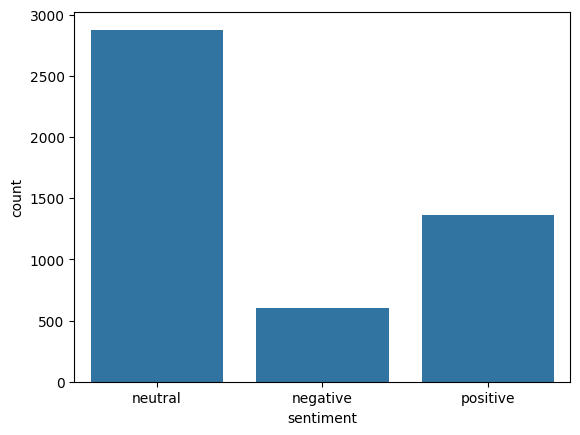

In [ ]:
sns.countplot(x="sentiment", data=df) # validando se mudou as classes

**OVERSAMPLING**

In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
from imblearn.pipeline import Pipeline as imbpipeline #importa o pipeline do imblearn
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from imblearn.over_sampling import SMOTE

X = df['clean_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline_smote = imbpipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('smote', SMOTE(random_state=42)),
    ('clf', LinearSVC())
])

pipeline_smote.fit(X_train, y_train)
y_pred_smote = pipeline_smote.predict(X_test)

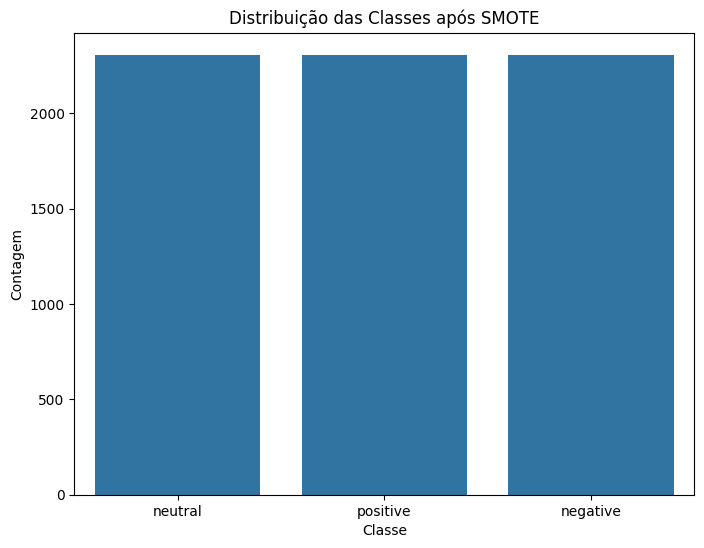

Contagem das classes após SMOTE:
sentiment
neutral     2308
positive    2308
negative    2308
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt # Import the pyplot module from matplotlib
# Obter as classes balanceadas após o SMOTE
y_resampled = pipeline_smote.named_steps['smote'].fit_resample(
    pipeline_smote.named_steps['vect'].fit_transform(X_train), y_train
)[1]

# Contar a distribuição das classes
class_distribution = pd.Series(y_resampled).value_counts()

# Visualizar a distribuição das classes
plt.figure(figsize=(8, 6))
sns.countplot(x=y_resampled)
plt.title('Distribuição das Classes após SMOTE')
plt.xlabel('Classe')
plt.ylabel('Contagem')
plt.show()

# Imprimir a contagem das classes
print('Contagem das classes após SMOTE:')
print(class_distribution)

**LIME**

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=79a4418561eb88207ccac0e2a754c2c8efca49e3c9874f6368535c09e189093d
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [ ]:
# Assuming 'text' is the column name containing the text data and 'sentiment' is the target column
X = df['text']
y = df['sentiment']

In [ ]:
X_train, X_test_2, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define and fit the pipeline
from lime.lime_text import LimeTextExplainer

pipeline = Pipeline([
    ('vect', CountVectorizer()),  # Convert text to numerical features
    ('tfidf', TfidfTransformer()),  # Apply TF-IDF transformation
    ('clf', LinearSVC()),  # Use a LinearSVC classifier (you can change this to another classifier)
])
pipeline.fit(X_train, y_train)  # Train the pipeline on the training data

explainer = LimeTextExplainer(class_names=df["sentiment"].unique())

def predict_proba(texts):
    return pipeline.decision_function(texts)  # Retorna scores para o LIME

# Escolhendo um exemplo aleatório do conjunto de testes
idx = np.random.randint(0, len(X_test_2))
sample_text = X_test_2.iloc[idx]
sample_label = y_test.iloc[idx]

print(f"Original text:\n{sample_text}")
print(f"Royal class: {sample_label}")

explanation = explainer.explain_instance(
    sample_text,
    predict_proba,
    num_features=10
)


explanation.show_in_notebook(text=True)

Original text:
The combined value of the orders is EUR 45mn .
Royal class: neutral


In [ ]:
import matplotlib.pyplot as plt

# Obtém as palavras mais importantes e seus pesos
lime_features = explanation.as_list()

# Exibe cada palavra com seu impacto na predição
print("Palavras mais importantes e seus pesos:")
for word, weight in lime_features:
    print(f"{word}: {weight:.4f}")


Palavras mais importantes e seus pesos:
orders: -0.6318
is: 0.5608
combined: -0.4604
value: 0.2838
EUR: -0.2471
The: 0.0970
the: 0.0918
of: -0.0268
45mn: 0.0012


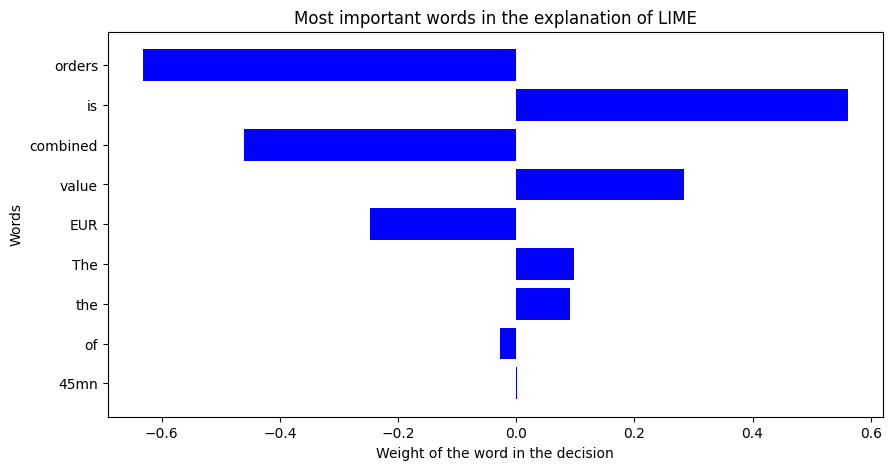

In [ ]:
# Separar palavras e pesos
words, weights = zip(*lime_features)

# Criar gráfico de barras
plt.figure(figsize=(10, 5))
plt.barh(words, weights, color="blue")
plt.xlabel("Weight of the word in the decision")
plt.ylabel("Words")
plt.title("Most important words in the explanation of LIME")
plt.gca().invert_yaxis()  # Inverter para mostrar a palavra mais importante no topo
plt.show()

In [ ]:
explanation_list = explanation.as_list()
lime_df = pd.DataFrame(explanation_list, columns=["Word", "Impact"])

# Ordenar por impacto
lime_df = lime_df.sort_values(by="Impact", ascending=False)

display(lime_df.head(20))  # Exibir as 20 palavras mais impactantes

,Word,Impact
1,is,0.560814
3,value,0.283816
5,The,0.097015
6,the,0.091844
8,45mn,0.001164
7,of,-0.026777
4,EUR,-0.247109
2,combined,-0.460352
0,orders,-0.631777


<Figure size 1000x600 with 0 Axes>

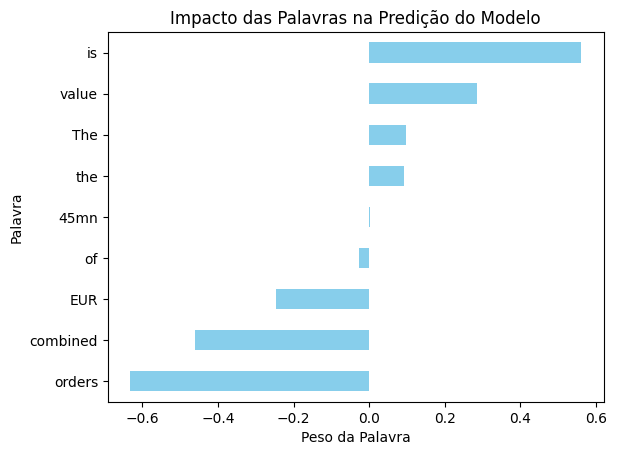

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
lime_df.plot(kind="barh", x="Word", y="Impact", color="skyblue", legend=False)
plt.xlabel("Peso da Palavra")
plt.ylabel("Palavra")
plt.title("Impacto das Palavras na Predição do Modelo")
plt.gca().invert_yaxis()  # Inverte o eixo para as palavras mais importantes ficarem no topo
plt.show()

In [ ]:
y_pred_2 = pipeline.predict(X_test_2)

**Métricas**

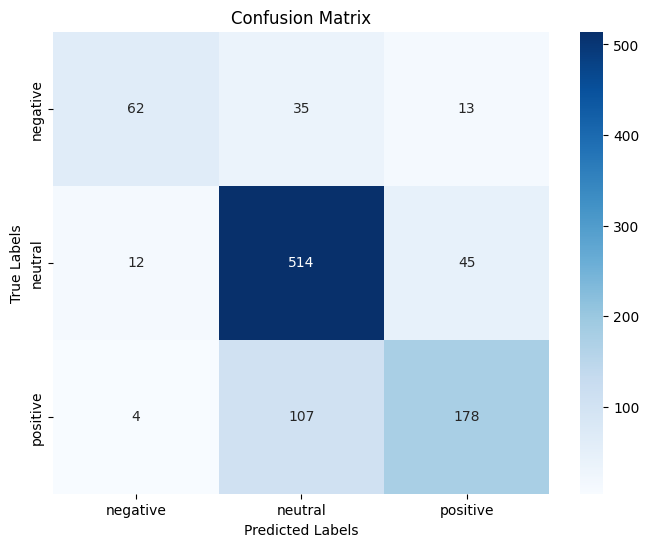

In [ ]:
# prompt: matriz de confusão

import matplotlib.pyplot as plt
# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred_2)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=pipeline.classes_, yticklabels=pipeline.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score # Import necessary metrics

accuracy = accuracy_score(y_test, y_pred_2)
precision = precision_score(y_test, y_pred_2, average='weighted')  # Usando 'weighted' para classes múltiplas
recall = recall_score(y_test, y_pred_2, average='weighted')
f1 = f1_score(y_test, y_pred_2, average='weighted')

print(f"Acurácia: {accuracy:.4f}")
print(f"Precisão: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

Acurácia: 0.7773
Precisão: 0.7761
Recall: 0.7773
F1-Score: 0.7700


**Attention Vizualization**

In [ ]:
#verificando a ordem das classes
print(pipeline.classes_)

['negative' 'neutral' 'positive']


In [ ]:
# Assumindo que 'pipeline' é o pipeline do SVM
pesos = pipeline.named_steps['clf'].coef_[0]  # Obter os pesos do SVM

# Obter os nomes das features
nomes_das_features = pipeline.named_steps['vect'].get_feature_names_out()

# Criar um DataFrame para visualizar os pesos
importancias_das_features = pd.DataFrame({'Feature': nomes_das_features, 'Weight': pesos})
importancias_das_features = importancias_das_features.sort_values(by='Weight', ascending=False)

print(importancias_das_features.head(20))  # Exibir as 20 features mais importantes

        Feature    Weight
2340  decreased  4.182074
2601       down  4.154460
3308       fell  3.188603
2334   declined  2.394367
2627    dropped  2.373889
2265        cut  1.898113
7441    slipped  1.858839
4942      lower  1.828492
2626       drop  1.810322
6852     result  1.727082
7611      staff  1.687423
5682        off  1.675016
3255       fall  1.659157
4427       jobs  1.548483
1281    because  1.519726
8709    warning  1.507875
4734        lay  1.429531
1961   compared  1.403888
8736       weak  1.356393
1310      below  1.343871


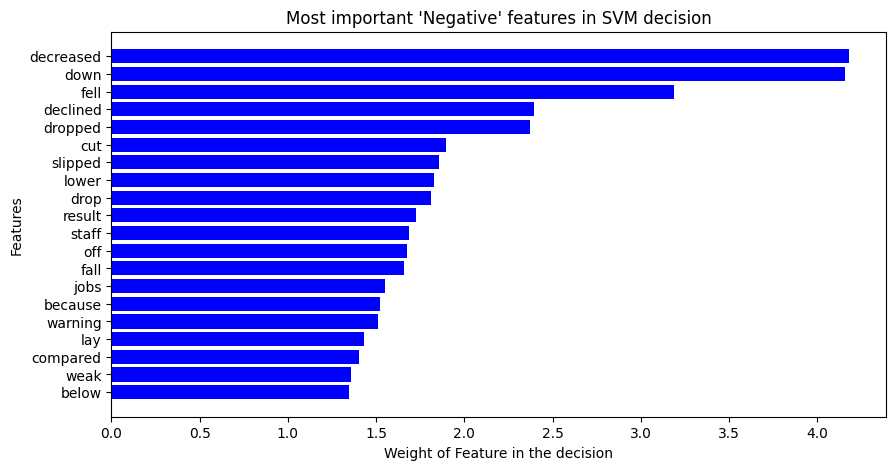

In [ ]:
plt.figure(figsize=(10, 5))
plt.barh(importancias_das_features['Feature'][:20], importancias_das_features['Weight'][:20], color="blue")
plt.xlabel("Weight of Feature in the decision")
plt.ylabel("Features")
plt.title("Most important 'Negative' features in SVM decision")
plt.gca().invert_yaxis()  # Inverter para mostrar a feature mais importante no topo
plt.show()

In [ ]:
# Assumindo que 'pipeline' é o pipeline do SVM
pesos = pipeline.named_steps['clf'].coef_[1]  # Obter os pesos do SVM

# Obter os nomes das features
nomes_das_features = pipeline.named_steps['vect'].get_feature_names_out()

# Criar um DataFrame para visualizar os pesos
importancias_das_features = pd.DataFrame({'Feature': nomes_das_features, 'Weight': pesos})
importancias_das_features = importancias_das_features.sort_values(by='Weight', ascending=False)

print(importancias_das_features.head(20))  # Exibir as 20 features mais importantes

            Feature    Weight
4351             is  1.718308
2190         covers  1.653153
4126       includes  1.604467
1018  approximately  1.593269
2444    development  1.544846
5865      ownership  1.446103
3872  headquartered  1.414126
7615          stake  1.279621
7987    technopolis  1.192463
926        amounted  1.183605
6800       research  1.142748
924           among  1.120412
6536          range  1.113549
5495          needs  1.097699
706        acquired  1.096704
1621        capital  1.083604
8193           took  1.074438
7630        started  1.063871
3092           eur9  1.053391
3079          eur69  1.053391


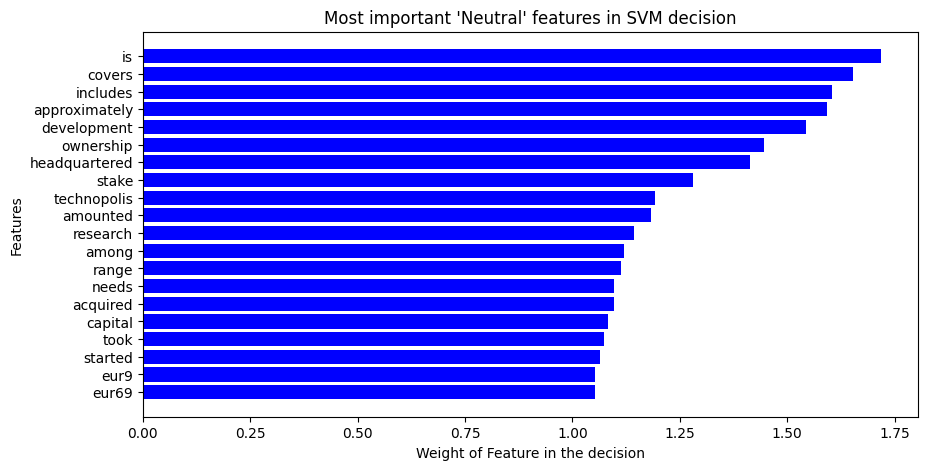

In [ ]:
plt.figure(figsize=(10, 5))
plt.barh(importancias_das_features['Feature'][:20], importancias_das_features['Weight'][:20], color="blue")
plt.xlabel("Weight of Feature in the decision")
plt.ylabel("Features")
plt.title("Most important 'Neutral' features in SVM decision")
plt.gca().invert_yaxis()  # Inverter para mostrar a feature mais importante no topo
plt.show()

In [ ]:
# Assumindo que 'pipeline' é o pipeline do SVM
pesos = pipeline.named_steps['clf'].coef_[2]  # Obter os pesos do SVM

# Obter os nomes das features
nomes_das_features = pipeline.named_steps['vect'].get_feature_names_out()

# Criar um DataFrame para visualizar os pesos
import pandas as pd
importancias_das_features = pd.DataFrame({'Feature': nomes_das_features, 'Weight': pesos})
importancias_das_features = importancias_das_features.sort_values(by='Weight', ascending=False)

print(importancias_das_features.head(20))  # Exibir as 20 features mais importantes

          Feature    Weight
6951         rose  3.260179
8453           up  3.182262
4136    increased  3.166680
4135     increase  3.060273
6234     positive  2.964478
3745         grew  2.598928
7362       signed  2.376983
8848          won  2.352675
1183      awarded  2.342578
4750      leading  2.256365
4107     improved  2.067022
6574        reach  1.973531
3174       expand  1.955015
3766       growth  1.897881
665          able  1.863380
3701         good  1.774355
4108  improvement  1.668906
3929       higher  1.630970
7091      savings  1.604870
3177    expanding  1.597956


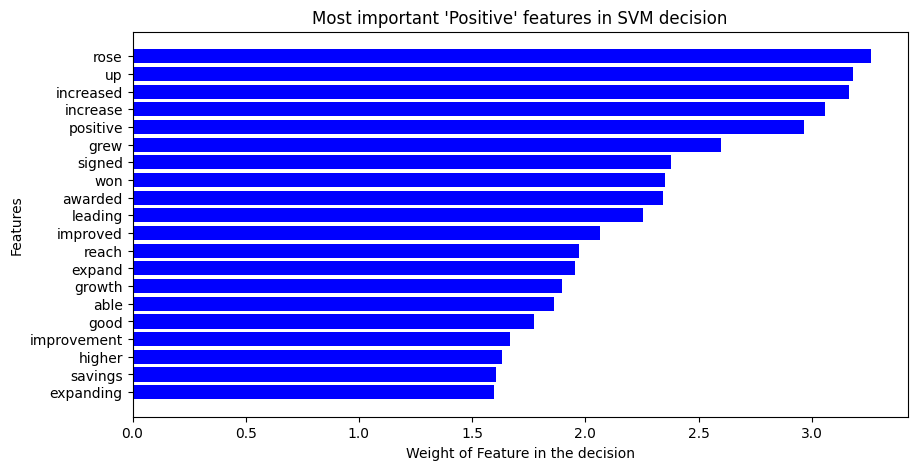

In [ ]:
plt.figure(figsize=(10, 5))
plt.barh(importancias_das_features['Feature'][:20], importancias_das_features['Weight'][:20], color="blue")
plt.xlabel("Weight of Feature in the decision")
plt.ylabel("Features")
plt.title("Most important 'Positive' features in SVM decision")
plt.gca().invert_yaxis()  # Inverter para mostrar a feature mais importante no topo
plt.show()